In [35]:
%autosave 0

Autosave disabled


In [36]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape

In [37]:
stack_idx = '15'
models = '1-23,25-27'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = True
add_intercept = True

### Read CV predictions and test

In [38]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [39]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27]


In [40]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [41]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [42]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [43]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [44]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
26
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.0005-350-cv.csv
model-27-lgb-feat_rm_n

In [45]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [46]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.368623,12.139520,6.452832e+05,13.377446,12.148343,6.477905e+05,13.381324,12.152221,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.964998,13.568430,3.164660e+06,14.967557,13.570989,3.127411e+06,14.955716,13.559149,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.099372,14.379417,9.832843e+06,16.101239,14.381284,9.745913e+06,16.092359,14.372404,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.360680,13.753334,1.274179e+07,16.360398,13.753051,1.259548e+07,16.348848,13.741502,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.950262,12.405236,1.114412e+06,13.923838,12.378812,1.131428e+06,13.938992,12.393966,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_23,pred_25,log_pred_25,log_parea_pred_25,pred_26,log_pred_26,log_parea_pred_26,pred_27,log_pred_27,log_parea_pred_27
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.235527,1.456214e+07,16.493936,15.264829,1.358120e+07,16.424197,15.195091,1.405424e+07,16.458435,15.229328
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.130465,3.903389e+06,15.177356,13.132737,3.915563e+06,15.180470,13.135851,3.932854e+06,15.184876,13.140257
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.837332,1.064055e+07,16.180183,13.681162,1.076414e+07,16.191730,13.692710,1.040041e+07,16.157355,13.658335
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.785526,6.006309e+06,15.608321,14.796389,6.034948e+06,15.613078,14.801146,5.905111e+06,15.591329,14.779397
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.195684,1.091787e+06,13.903327,12.143065,1.096191e+06,13.907353,12.147091,1.048505e+06,13.862877,12.102615


### Check models scores

In [47]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-25 5908.874238
24 model-26 5918.873998
25 model-27 5892.873194


In [48]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [49]:
def objective(x, metric):
    cv_pred_final = cv.loc[:,cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    global best_score
    global best_coeffs
    global best_hit
    hit = cal_score(cv['total_price'], cv_pred_final)
    score = cal_mape(cv['total_price'], cv_pred_final)
#    if score > best_score[metric]:
    if score < best_score[metric]:
        best_score[metric] = score
        best_hit[metric] = hit
        best_coeffs[metric] = x.copy()
#        print('find better score:')
#        print('score: ', score)
#        print('coeffs: ', x)
#        print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Optimize

In [50]:
best_score = {}
best_coeffs = {}
best_hit = {}

len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [ [1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)],
       [np.random.randn()+1/len_x for i in range(len_x)] ]

#for metric in ['mape']:
for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 1
    best_hit[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        try:
            display(minimize(objective, x0, args=(metric), tol=1e-4))
        except:
            pass

Optimizing with init x0: [0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035]



      fun: 0.1230501897513577
 hess_inv: array([[ 4.17255646e+01, -4.84040011e+00,  1.31139867e+01,
         1.74947597e+01, -1.12161277e+01, -3.38325264e+01,
        -2.65583732e+00, -3.10828432e+00, -2.49844831e+01,
         7.02608717e+01, -5.52809584e+00,  9.12890436e+00,
        -4.71815389e+00,  3.82727706e+01,  3.37396299e+01,
        -3.97105875e+01, -1.51427228e+02,  9.20539134e+01,
         1.20674121e+02, -6.14191901e+01, -1.37262694e+01,
         2.85680262e+01,  4.44207376e+00, -9.60122924e+00,
        -1.03079636e+02,  7.84313060e-02,  4.35618059e+00],
       [-4.84039764e+00,  4.53431518e+00, -6.53884936e+00,
        -9.00214840e+00,  1.84549143e-02,  1.11556491e+01,
         1.07778790e+00,  1.20319874e+00,  1.30571118e+01,
        -2.17501007e+01,  1.01700863e+00, -6.34519984e+00,
         3.05666558e+00, -2.17433785e-01, -1.80349053e+01,
         4.02187833e+00,  4.34165310e+01, -2.45459024e+01,
        -2.94646662e+01,  2.68648374e+00,  2.91510480e+00,
        -4.178

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



      fun: 1.0
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0

Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]



      fun: 1.000002081631378
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]



      fun: 0.999997287461331
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/scipy/optimize/optimize.py:670: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


      fun: 9.252131655651953e+47
 hess_inv: array([[ 0.96161376, -0.0385756 , -0.03835815, -0.03823745, -0.03852701,
        -0.03834506, -0.03870083, -0.0390836 , -0.03835873, -0.03836425,
        -0.0375438 , -0.03841134, -0.03902904, -0.0383636 , -0.03836607,
        -0.03837019, -0.03836447, -0.03836176, -0.03834832, -0.03836945,
        -0.03856293, -0.03854463, -0.03835779, -0.03834866, -0.038346  ,
        -0.03830921, -0.00219408],
       [-0.0385756 ,  0.9612341 , -0.03854738, -0.03842607, -0.03871707,
        -0.03853421, -0.03889175, -0.0392764 , -0.03854796, -0.03855351,
        -0.03772901, -0.03860083, -0.03922157, -0.03855285, -0.03855534,
        -0.03855947, -0.03855372, -0.038551  , -0.03853749, -0.03855873,
        -0.03875317, -0.03873477, -0.03854701, -0.03853783, -0.03853516,
        -0.03849819, -0.0022049 ],
       [-0.03835815, -0.03854738,  0.96166991, -0.03820947, -0.03849882,
        -0.038317  , -0.03867251, -0.039055  , -0.03833066, -0.03833618,
        -0

Optimizing with init x0: [-1.5425407923213, -2.738845217837525, -1.3782326637737152, 0.06405428101931156, 0.243975674028165, -0.300487074428654, -0.0549960791413652, 0.9656603037810529, -1.3315445892110502, 2.657642855136579, -0.8020135617032431, -0.12392265356411711, -1.3658379646521308, -0.07464178069627561, 1.1730803466778597, 0.40706710670444185, 0.21323845202542888, 0.6958744531964038, 0.3364849716356447, -0.9557879322598639, -0.615794535958222, 0.5713265865093238, -0.13675312877027268, 1.4946912110235453, -1.7612735344005959, 0.5592027748282324, 0.09863177543283777]



      fun: 1.000002081631378
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
    

Optimizing with init x0: [-1.6849050447668004, -0.17281109406701642, -0.8570422164562412, 1.072129099565722, -0.7925164346006099, -0.5040721249529578, 0.11185655821809501, 1.1806210758082083, 1.0394592585783122, -1.4502219463789086, 0.16463865049438509, -0.2311628943383049, 0.835376713868653, -0.01567852172175311, 2.0394697955024537, 0.6093202427023969, 0.9691643206168621, 0.8342054250490702, -1.478959818569071, 0.7578754460659425, 0.4233006559141746, 0.5054823275720979, 0.8826580907092205, 0.777084396839292, 1.4868105659253705, -1.0112348725977205, -0.0761671504584077]



      fun: 0.1230606399549136
 hess_inv: array([[ 4.59470236e+02,  3.22614762e+00, -1.35193576e+02,
        -1.18641941e+01, -3.59767787e+01, -3.02417649e+02,
        -3.71915837e+00,  4.88224223e+00, -1.45031614e+01,
        -3.30332422e+01,  1.17877794e+00, -9.39154587e+00,
         7.09045625e+00,  1.08919674e+02, -5.49278985e+01,
        -9.67959079e+01,  4.59998268e+00,  8.91536938e+01,
        -8.09418852e+00, -4.40350705e+01,  3.13865612e+01,
        -2.05121443e+00, -7.73742315e+00,  3.03763235e+01,
        -5.72998390e+01,  7.72404008e+01, -5.83084014e+00],
       [ 3.22615132e+00,  4.07681925e+01, -8.36524308e+00,
        -1.98818527e+00, -1.01847976e+01,  7.41848746e-01,
        -4.04226815e+00, -1.25186127e+01,  4.40314348e+01,
         1.17231388e+01,  9.62330554e-01, -1.04385660e+01,
        -1.18191505e+01, -1.00576119e+02,  5.17880135e+01,
         8.99682595e+01, -7.37967260e+01, -3.66115675e+01,
         6.18415997e+01,  2.54820229e+01,  1.39887776e+01,
         4.930

Optimizing with init x0: [-1.3553526810333942, 0.11472029660622396, -0.5989139197669706, -0.6060668840783157, 0.18911478710862858, 0.2366619339852233, 0.33557961254871704, 0.8267096037116881, 0.12902476975116645, 0.9648788456471742, -1.3215202146389968, -0.35581893629596484, 0.31710578288462343, 0.8831350376338183, -1.0441503706290234, 0.33061011224914166, -1.6296520626902817, -0.607668721975545, 1.267781296302577, 0.5694500591684086, -0.9709428819275214, 0.24607535462803182, 0.3397540355166775, -1.0164376197341012, 0.31491100343049755, 0.9929455149360926, 0.30017740510302854]



      fun: 1.0000020816313364
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Optimizing with init x0: [0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035]



      fun: 1643766.8059386734
 hess_inv: array([[ 3.29539312e-05, -3.16953560e-07, -3.88856897e-06,
        -1.12393171e-06,  8.60584997e-06, -1.50910512e-06,
        -1.64683095e-06,  3.14860066e-06, -1.70436814e-05,
        -9.21972017e-05, -1.53825400e-07, -5.14167043e-06,
        -1.70042151e-06, -3.24261389e-05,  1.24156628e-04,
        -6.80048074e-05,  9.26966783e-05, -2.95007520e-05,
         8.99521914e-06, -3.37311213e-05, -1.97294371e-05,
         9.71676200e-06, -1.52553215e-06,  1.70625789e-05,
         1.74583408e-05, -5.24197388e-06,  1.42162501e-06],
       [-3.19221707e-07,  1.06332347e-06,  1.91108376e-06,
        -1.57397373e-07, -9.40728233e-08, -2.33532902e-06,
         2.59426133e-07, -5.74378503e-07,  1.67626266e-07,
        -2.40573443e-07,  1.04434864e-07, -1.69038955e-07,
        -1.08809755e-07,  2.56782420e-06, -7.85779715e-06,
         8.53912043e-06, -4.62899357e-07, -2.51736139e-06,
        -2.31992854e-06,  1.54764336e-06, -1.20822064e-06,
         1.350

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]



      fun: 12937280.994235411
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]



      fun: 12937256.633562893
 hess_inv: array([[ 0.96166475, -0.03886477, -0.03834821, -0.03810221, -0.03820085,
        -0.03835593, -0.03858629, -0.03920931, -0.03838141, -0.03836636,
        -0.03762379, -0.03844436, -0.03889894, -0.03836997, -0.03836988,
        -0.03836219, -0.03837078, -0.03835917, -0.03836533, -0.03838638,
        -0.03830204, -0.03827502, -0.03833923, -0.03837215, -0.03836346,
        -0.03831493, -0.00220666],
       [-0.03886477,  0.9605984 , -0.03887791, -0.0386285 , -0.03872851,
        -0.03888573, -0.03911927, -0.0397509 , -0.03891156, -0.0388963 ,
        -0.03814348, -0.03897538, -0.03943624, -0.03889997, -0.03889988,
        -0.03889207, -0.03890079, -0.03888902, -0.03889526, -0.0389166 ,
        -0.0388311 , -0.03880371, -0.0388688 , -0.03890218, -0.03889337,
        -0.03884416, -0.00223714],
       [-0.03834821, -0.03887791,  0.96163882, -0.03811509, -0.03821377,
        -0.0383689 , -0.03859933, -0.03922256, -0.03839438, -0.03837933,
        -0.03

Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [-1.5425407923213, -2.738845217837525, -1.3782326637737152, 0.06405428101931156, 0.243975674028165, -0.300487074428654, -0.0549960791413652, 0.9656603037810529, -1.3315445892110502, 2.657642855136579, -0.8020135617032431, -0.12392265356411711, -1.3658379646521308, -0.07464178069627561, 1.1730803466778597, 0.40706710670444185, 0.21323845202542888, 0.6958744531964038, 0.3364849716356447, -0.9557879322598639, -0.615794535958222, 0.5713265865093238, -0.13675312877027268, 1.4946912110235453, -1.7612735344005959, 0.5592027748282324, 0.09863177543283777]



      fun: 12937280.994235411
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Optimizing with init x0: [-1.6849050447668004, -0.17281109406701642, -0.8570422164562412, 1.072129099565722, -0.7925164346006099, -0.5040721249529578, 0.11185655821809501, 1.1806210758082083, 1.0394592585783122, -1.4502219463789086, 0.16463865049438509, -0.2311628943383049, 0.835376713868653, -0.01567852172175311, 2.0394697955024537, 0.6093202427023969, 0.9691643206168621, 0.8342054250490702, -1.478959818569071, 0.7578754460659425, 0.4233006559141746, 0.5054823275720979, 0.8826580907092205, 0.777084396839292, 1.4868105659253705, -1.0112348725977205, -0.0761671504584077]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


Optimizing with init x0: [-1.3553526810333942, 0.11472029660622396, -0.5989139197669706, -0.6060668840783157, 0.18911478710862858, 0.2366619339852233, 0.33557961254871704, 0.8267096037116881, 0.12902476975116645, 0.9648788456471742, -1.3215202146389968, -0.35581893629596484, 0.31710578288462343, 0.8831350376338183, -1.0441503706290234, 0.33061011224914166, -1.6296520626902817, -0.607668721975545, 1.267781296302577, 0.5694500591684086, -0.9709428819275214, 0.24607535462803182, 0.3397540355166775, -1.0164376197341012, 0.31491100343049755, 0.9929455149360926, 0.30017740510302854]



      fun: 12937280.994235318
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Optimizing with init x0: [0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035, 0.037037037037037035]



      fun: 179996926437202.25
 hess_inv: array([[ 1.11856133e-11,  1.18535433e-12,  1.29835585e-11,
         5.06826879e-13, -3.18083048e-12, -1.62172548e-11,
        -3.79920230e-13, -3.38600302e-13, -7.88237405e-12,
         1.81076168e-11,  1.06680639e-12,  3.79202223e-13,
        -1.23733326e-12, -2.86975939e-11,  1.38703065e-11,
         4.04842345e-14,  2.02041242e-11, -1.52719125e-11,
         3.51155912e-11, -3.01417180e-11,  1.48513522e-11,
        -1.24153838e-11,  1.42175432e-12, -2.77690124e-12,
        -1.11904274e-11, -5.93552130e-13, -9.36772038e-12],
       [-1.41828496e-13, -1.63885769e-12, -6.05166078e-12,
        -8.22278789e-13,  1.43225443e-12,  6.18722884e-12,
         7.66546502e-13,  1.91031009e-12, -1.64088117e-12,
         4.94334303e-12, -1.27288710e-13, -5.42165152e-14,
        -1.33779186e-12, -9.97932184e-12,  6.72252862e-12,
         1.47790631e-12,  6.71127458e-12, -6.06054243e-12,
         8.04264016e-12, -1.84957754e-12,  1.81352379e-12,
        -3.033

Optimizing with init x0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]



      fun: 3217083637879235.0
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Optimizing with init x0: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]



/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/usr/local/lib/python3.7/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


      fun: 5.074802053945243e+197
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Optimizing with init x0: [-1.5425407923213, -2.738845217837525, -1.3782326637737152, 0.06405428101931156, 0.243975674028165, -0.300487074428654, -0.0549960791413652, 0.9656603037810529, -1.3315445892110502, 2.657642855136579, -0.8020135617032431, -0.12392265356411711, -1.3658379646521308, -0.07464178069627561, 1.1730803466778597, 0.40706710670444185, 0.21323845202542888, 0.6958744531964038, 0.3364849716356447, -0.9557879322598639, -0.615794535958222, 0.5713265865093238, -0.13675312877027268, 1.4946912110235453, -1.7612735344005959, 0.5592027748282324, 0.09863177543283777]



      fun: 3217083637879235.0
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

Optimizing with init x0: [-1.6849050447668004, -0.17281109406701642, -0.8570422164562412, 1.072129099565722, -0.7925164346006099, -0.5040721249529578, 0.11185655821809501, 1.1806210758082083, 1.0394592585783122, -1.4502219463789086, 0.16463865049438509, -0.2311628943383049, 0.835376713868653, -0.01567852172175311, 2.0394697955024537, 0.6093202427023969, 0.9691643206168621, 0.8342054250490702, -1.478959818569071, 0.7578754460659425, 0.4233006559141746, 0.5054823275720979, 0.8826580907092205, 0.777084396839292, 1.4868105659253705, -1.0112348725977205, -0.0761671504584077]



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in expm1
  """


Optimizing with init x0: [-1.3553526810333942, 0.11472029660622396, -0.5989139197669706, -0.6060668840783157, 0.18911478710862858, 0.2366619339852233, 0.33557961254871704, 0.8267096037116881, 0.12902476975116645, 0.9648788456471742, -1.3215202146389968, -0.35581893629596484, 0.31710578288462343, 0.8831350376338183, -1.0441503706290234, 0.33061011224914166, -1.6296520626902817, -0.607668721975545, 1.267781296302577, 0.5694500591684086, -0.9709428819275214, 0.24607535462803182, 0.3397540355166775, -1.0164376197341012, 0.31491100343049755, 0.9929455149360926, 0.30017740510302854]



      fun: 3217083637879218.5
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
   

In [51]:
display(best_score)
display(best_coeffs)
display(best_hit)

{'mape': 0.12305018975076526,
 'mae': 0.12456510730426937,
 'mse': 0.1319596455366107}

{'mape': array([-0.13821485,  0.01513176,  0.14133131,  0.0600924 ,  0.08612088,
         0.02192111,  0.02069   ,  0.10131839, -0.06190798, -0.18723071,
        -0.09795221,  0.01677294,  0.03719163,  0.22358007, -0.35348826,
        -0.01938971,  0.28573474,  0.35224271,  0.07208768, -0.47872561,
        -0.03239947,  0.11761464,  0.11205033,  0.39758047,  0.01869198,
         0.29613723, -0.10616244]),
 'mae': array([0.03843259, 0.03843259, 0.03843259, 0.03843259, 0.03822372,
        0.03843259, 0.03843259, 0.03846741, 0.03843259, 0.03843259,
        0.03843259, 0.03843259, 0.03843259, 0.03843259, 0.03843259,
        0.03843259, 0.03843259, 0.03843259, 0.03843259, 0.03843259,
        0.03822372, 0.03822372, 0.03843261, 0.03843259, 0.03843259,
        0.03843259, 0.00285459]),
 'mse': array([0.03862671, 0.03894816, 0.03862671, 0.03884101, 0.03632304,
        0.03862671, 0.03921603, 0.03894816, 0.03862671, 0.03884101,
        0.03862671, 0.0390553 , 0.03900173, 0.03878744, 0.03878744,

{'mape': 5959.876949810249, 'mae': 5920.875434892696, 'mse': 5786.868040354463}

### Compute submission

In [52]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['mape'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}_maxmape.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}_maxmape.csv'.format(stack_idx, models), index=False)

### Plots

In [53]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


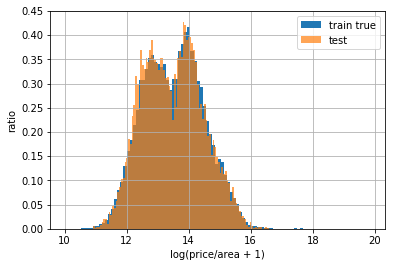

In [54]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

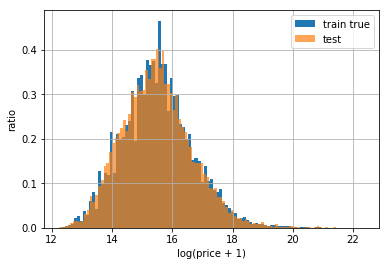

In [55]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

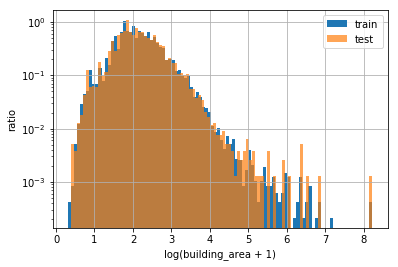

In [56]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()

### Make coeffs for opt

In [ ]:
mlist = [3, 4, 5, 8, 10, 12, 13, 15, 16, 17, 18, 19, 22, 23, 25, 26, 27] # get from mean
print([1/len(mlist) if i in mlist else 0 for i in list(range(1,24)) + list(range(25,28))])